# 对于2018年CIC2rd的反馈数据进行文本分类

## install dependency and initial session and S3 bucket

In [1]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3
from random import shuffle

sess = sagemaker.Session()

role = get_execution_role()
print(role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

bucket = 'ray-ai-ml-bjs' #sess.default_bucket() # Replace with your own bucket name if needed
print(bucket)
prefix = 'classification/blazingtext/bmwticket' 

arn:aws-cn:iam::876820548815:role/Sagemaker-Bootcamp-SageMakerExecutionRole-Z3VF78G260T1
ray-ai-ml-bjs


In [2]:
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple jieba --upgrade
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple paddlepaddle-tiny

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 19.2 MB 438 kB/s eta 0:00:011
  Created wheel for jieba: filename=jieba-0.42.1-py3-none-any.whl size=19314478 sha256=692c6252c26d39dc49c5595d0fa5be623e45f33d4cdfd58efc5cab7efc462054
  Stored in directory: /home/ec2-user/.cache/pip/wheels/de/9e/4f/5a72ec71510dfe06f9bbc96ad06077629654f87fb05766ab46
Successfully built jieba
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 39.8 MB 67 kB/s eta 0:00:0101
     |████████████████████████████████| 17.3 MB 67 kB/s eta 0:00:0101
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.1
    Uninstalling numpy-1.18.1:
      Successfully uninstalled numpy-1.18.1
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip in

## Prepare classification category
- All return '\n' convert to `_` for example `LSC\n远程指令` convert to `LSC_远程指令`
- Convert alphabet to Uppercase

In [3]:
import jieba
import re
import pandas as pd
import os
import csv

## 读入原始Excel文件，并通过参数 usecols 提取相关列，保存为csv文件，作为算法Raw data输入

In [5]:
excel_data_df = pd.read_excel('20201026_customer feedback_with comments.xlsx', sheet_name='Sheet1', usecols=['channel', 'Rating', 'Customer Comment', 'Positive or Negative', 'Coding level 1', 'Coding level 2'], index_col=None)
#print(excel_data_df[0:5])

raw_app_comments_file = 'raw-app-comments-1030.csv'
excel_data_df.to_csv(raw_app_comments_file, index=False)
sentiment_input_with_def = []
sentiment_input_without_def = []
sentiment_def= []
input_with_category = []
input_without_category = []
data_offset_counts = {}
category_def = []

csv_data_df = pd.read_csv(raw_app_comments_file, delimiter=',', index_col=None)
csv_data_df.head()

,channel,Rating,Customer Comment,Positive or Negative,Coding level 1,Coding level 2
0,NPS,10.0,新的APP,正向,其他,Other
1,NPS,10.0,good job,正向,其他,Other
2,NPS,10.0,145666,正向,其他,Other
3,NPS,10.0,测试,正向,其他,Other
4,NPS,10.0,已经成功推荐了,正向,其他,Other


## 处理分类, 如果分类有更新，需要重新运行文件 取消注释 modify_label_file，重新运行
 - 分类标签处理会去掉换行回车键
 - 多分类标签，标签之间通过'__'拼接为一条
 - 字母转换为大写字母
 - 标签格式：数字,标签字符串，例如1154,互联驾驶使用年限__USABILITY/DIFFICULT TO USE

In [6]:
def handle_category_str(coding_level1, coding_level2):
    if (coding_level1!='' and pd.notnull(coding_level1)) and (coding_level2!='' and pd.notnull(coding_level2)):
        category_str = str(coding_level1).split('\n', 1)[0] + "__" + str(coding_level2).split('\n', 1)[0]
        category_str = category_str.upper()
    elif (coding_level1=='' or pd.isnull(coding_level1)):
        category_str = str(coding_level2).split('\n', 1)[0]
    elif (coding_level2=='' or pd.isnull(coding_level2)):
        category_str = str(coding_level1).split('\n', 1)[0]
    else:
        category_str = 'No_Category'
    return category_str


def modify_label_file(csv_data_df):
    for index, data in csv_data_df.iterrows():
        coding_level1 = data['Coding level 1']
        coding_level2 = data['Coding level 2']
        category_str = handle_category_str(coding_level1, coding_level2)
        category_def.append(category_str)

    category_def_unique = list(set(category_def))
    print(category_def_unique)
    temp_category_id = 1047
    for x in category_def_unique:
        category_id = temp_category_id
        print(category_id,",",x)
        temp_category_id +=1

#modify_label_file(csv_data_df)
        
index_to_label = {} #1001:APP显示问题
label_to_index = {} #APP显示问题:1001
with open("app-comments-multiple-label.txt") as f:
    for i,label in enumerate(f.readlines()):
        ll = label.strip().split(',')
        index_to_label[ll[0]] = ll[1].upper()
        label_to_index[ll[1].upper()] = ll[0]
print(label_to_index)

{'APP显示问题': '1001', 'APP版本问题': '1002', 'APP登陆问题': '1003', 'APP车辆信息显示问题': '1004', 'BON': '1005', 'CARLIFE': '1006', 'CARPLAY': '1007', 'ETC': '1008', 'GPS': '1009', 'IBA用户手册': '1010', 'LSC': '1011', 'LSC_远程指令': '1012', 'PIN码': '1013', 'POI': '1014', 'QQ音乐': '1015', 'RSU': '1016', 'RTTI': '1017', 'SIM卡相关': '1019', 'WIFI': '1020', '个性化设置': '1021', '二手车预激活问题': '1022', '会员': '1072', '其他': '1024', '即时充电': '1025', '喜马拉雅': '1026', '地图自动更新服务': '1027', '天猫精灵': '1028', '实时路况功能': '1029', '意见建议': '1030', '数字钥匙': '1031', '智慧停车': '1032', '更新BMW服务': '1033', '满意': '1034', '节日祝福': '1035', '行程摘要': '1036', '行车摘要': '1037', '车机端登录': '1038', '远程3D视图': '1039', '远程指令': '1040', '远程指令_LSC': '1041', '远程服务': '1042', '远程软件升级': '1043', '违章代缴': '1044', '预开通激活': '1045', '预激活开通': '1046', '其他/APP__OTHER': '1047', 'APP/社群__USABILITY/DIFFICULT TO USE': '1048', '车机端BMW CONNECTED/BMW云端互联__LOGINFAULT': '1049', '其他/蓝牙__CONNECTION FAULT': '1050', '其他/APP__USABILITY/DIFFICULT TO USE': '1051', '车机端BMW CONNECTED/BMW云端互联__USABILIT

## 处理情感数据
- Rule of NPS,
    - Positive: 10-9
    - Neutral: 8-7
    - Negative: 6-1
 
- Rule of App store:
    - Positive Reviews: 5-4
    - Negative Reviews: 3-1

In [7]:
def get_sentiment(channel, rating, sentiment):
    sentiment_switcher = { 
        "正向": "Positive", 
        "中性": "Neutral", 
        "负向": "Negative", 
    } 
    return_sentiment = sentiment_switcher.get(sentiment, None) 
    if channel == 'NPS':
        if rating >=9:
            return_sentiment = 'Positive'
        elif rating >=7:
            return_sentiment = 'Neutral'
        else:
            return_sentiment = 'Negative'
    elif channel.endswith("App Store"):
        if rating >=4:
            return_sentiment = 'Positive'
        else:
            return_sentiment = 'Negative'
    return return_sentiment

def unit_test_get_sentiment():
    # Unit Test for get_sentiment
    print("NPS")
    print(get_sentiment("NPS", 9, "Neutral"))
    print(get_sentiment("NPS", 9, "Negative"))
    print(get_sentiment("NPS", 7, "Positive"))
    print(get_sentiment("NPS", 8, "Negative"))
    print(get_sentiment("NPS", 6, "Positive"))
    print(get_sentiment("NPS", 5, "Negative"))
    print(get_sentiment("NPS", 4, "Neutral"))
    print("App Store")
    print(get_sentiment("IOS App Store", 4, "Neutral"))
    print(get_sentiment("Andior App Store", 5, "Negative"))
    print(get_sentiment("HuaWeiApp Store", 3, "Positive"))
    print(get_sentiment("Oppp App Store", 2, "Negative"))
    print(get_sentiment("Xiao Mi App Store", 1, "Positive"))
    print("feedback")
    print(get_sentiment("feedback", 0, "正向"))
    print(get_sentiment("feedback", 0, "中性"))
    print(get_sentiment("feedback", 0, "负向"))

# Unit Test
#unit_test_get_sentiment()

## 将原始数据进行预处理
- 提取出分类，情感，评论，渠道，评分等
- 分为有分类和无分类
- 分为有情感类比和无情感类比
- 将分类标签格式转换为：index_!_分类标签_!_评论，例如 1011_!_LSC_!_定位不准，乱定位

In [8]:
category_def.clear()
input_without_category.clear()
input_with_category.clear()
sentiment_input_without_def.clear()
sentiment_input_with_def.clear()
sentiment_def.clear()
data_offset_counts.clear()

for index, data in csv_data_df.iterrows():
    channel_str = data['channel']
    rating_num = data.get('Rating',0)
    comment_str = data['Customer Comment']
    sentiment_str = data['Positive or Negative']
    coding_level1 = data['Coding level 1']
    coding_level2 = data['Coding level 2']
    category_str = handle_category_str(coding_level1, coding_level2)
    if (category_str == 'No_Category' or category_str =='nan'):
        input_without_category.append(str(comment_str))
        #print(channel_str, rating_num, comment_str, sentiment_str, coding_level1, coding_level2)
    else:
        category_def.append(category_str)
        category_index = label_to_index.get(category_str, None)
        input_with_category.append(str(category_index) + '_!_' + str(category_str) + '_!_' + str(comment_str))
        data_offset_counts[category_str] = data_offset_counts.get(category_str, 0) + 1
    
    sentiment_result = get_sentiment(channel_str, rating_num, sentiment_str)
    if sentiment_str==None or pd.isnull(sentiment_result):
        sentiment_input_without_def.append(str(comment_str))
    else:
        sentiment_input_with_def.append(str(comment_str))
        sentiment_def.append(str(sentiment_str))


## 预览原始数据预处理结果

In [26]:
print("带有分类输入数据预览", input_with_category[0:3],'\n')
print("没有分类输入数据预览", input_without_category[0:3],'\n')
print("原始输入数据 - 总数: ",len(csv_data_df), " , 带有分类的输入: ", len(input_with_category), " , 没有分类的输入: ", len(input_without_category), '\n')

print("分类分布统计: ")
items = list(data_offset_counts.items())
items.sort(key=lambda x: x[1], reverse=True)
class_names = []
class_values = []
for i in range(30):
    word, count = items[i]
    category_index = label_to_index.get(word, None)
    class_names.append(category_index)
    class_values.append(count)
    print("{:<10}{:>7}".format(word, count))

带有分类输入数据预览 ['1173_!_其他__OTHER_!_新的APP', '1173_!_其他__OTHER_!_good job', '1173_!_其他__OTHER_!_145666'] 

没有分类输入数据预览 ['v', '10', '2'] 

原始输入数据 - 总数:  7578  , 带有分类的输入:  6941  , 没有分类的输入:  637 

分类分布统计: 
其他__OTHER    3329
其他/APP__USABILITY/DIFFICULT TO USE    897
APP车辆信息显示__USABILITY/DIFFICULT TO USE    294
远程指令__USABILITY/DIFFICULT TO USE    228
其他/APP__CONVENIENCE    206
其他__USABILITY/DIFFICULT TO USE    163
其他/APP__OTHER    163
预激活__USABILITY/DIFFICULT TO USE    154
其他/APP__DESIGN / VISUALS (WEB)    152
APP车辆信息显示__UPDATE NOT POSSIBLE    142
远程3D视图__USABILITY/DIFFICULT TO USE    117
会员__OTHER     100
预开通激活__USABILITY/DIFFICULT TO USE     88
意见建议-CONCERN&ADVICE__CONCERN&ADVICE     51
其他/APP__CONNECTION FAULT     49
其他__DESIGN / VISUALS (WEB)     48
定位__USABILITY/DIFFICULT TO USE     46
数字钥匙功能__USABILITY/DIFFICULT TO USE     46
其他/APP__UPDATE NOT POSSIBLE     44
互联驾驶信息更改__USABILITY/DIFFICULT TO USE     42
APP功能显示__USABILITY/DIFFICULT TO USE     38
其他__BRAND POWER     38
其他/APP个性化设置__USABILITY

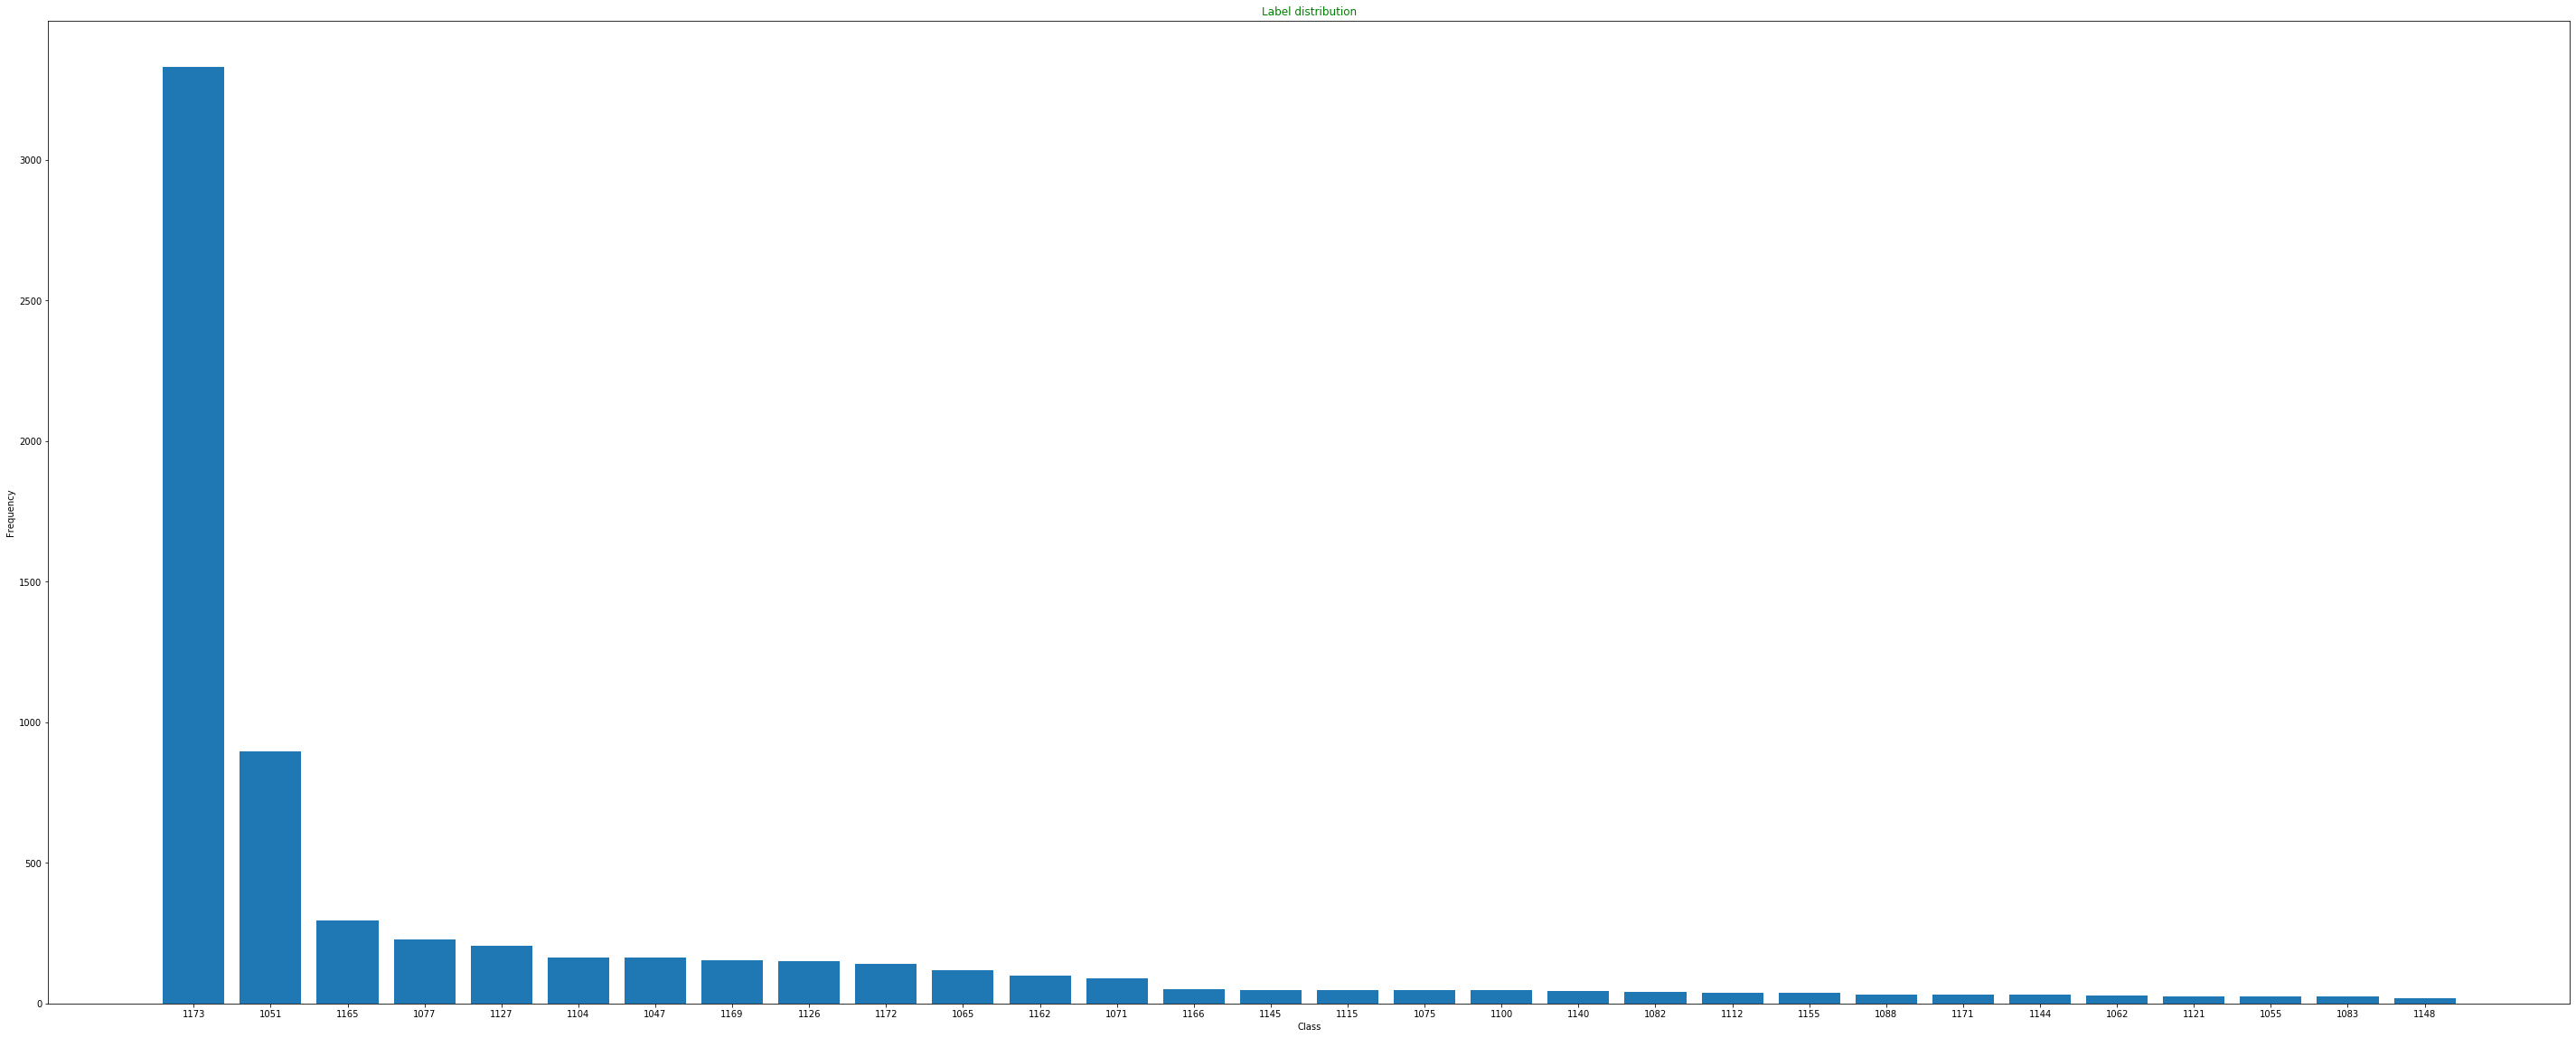

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50,20))
plt.bar(class_names,class_values)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Label distribution", color="green")
plt.show()

In [34]:
print('情感数据输入: ',len(csv_data_df), ' , 带有情感标识的评论: ', len(sentiment_input_with_def), ' , 不带有情感标识的评论: ', len(sentiment_input_without_def), '\n')
#print('\n','sentiment_input with definition: ', len(sentiment_input_with_def), 'preview 10 items')
#print(sentiment_input_with_def[0:10])

情感数据输入:  7578  , 带有情感标识的评论:  7578  , 不带有情感标识的评论:  0 



## 调用AWS comprehend API 进行情感分析
- 启动一个Terminal, 配置一个aws cli profile: aws configure --profile global
- 如果不进行文本情感分析，那么可以直接跳到`中文分词处理`章节运行

1. 示例检查API是否工作

In [39]:
session = boto3.Session(profile_name='global', region_name='us-east-1')
comprehend_client = session.client('comprehend')
sample_list = ['喜马拉雅FM可以像QQ音乐一样直接在车上应用么？还是只能在CARPLAY上使用', '你好，为什么在互联驾驶这个功能中定位不了我车了，显示说我在车上的GPS关闭了，但是我检查过了，也开着啊什么问题呢', '我喜欢使用互联驾驶这个功能中路线规划']
for s_input in sample_list:
    sentiment_response = comprehend_client.detect_sentiment(Text=s_input, LanguageCode='zh')
    sentiment_str = sentiment_response['Sentiment']
    sentiment_score = json.dumps(sentiment_response['SentimentScore'])
    print('评论: ', s_input, ' - 情感: ', sentiment_str , ' - 情感置信度: ' , sentiment_score , '\n')


评论:  喜马拉雅FM可以像QQ音乐一样直接在车上应用么？还是只能在CARPLAY上使用  - 情感:  NEUTRAL  - 情感置信度:  {"Positive": 0.010348141193389893, "Negative": 0.09099732339382172, "Neutral": 0.8986498713493347, "Mixed": 4.764513505506329e-06} 

评论:  你好，为什么在互联驾驶这个功能中定位不了我车了，显示说我在车上的GPS关闭了，但是我检查过了，也开着啊什么问题呢  - 情感:  NEGATIVE  - 情感置信度:  {"Positive": 0.0004973442992195487, "Negative": 0.9937689900398254, "Neutral": 0.005685589741915464, "Mixed": 4.8103760491358116e-05} 

评论:  我喜欢使用互联驾驶这个功能中路线规划  - 情感:  POSITIVE  - 情感置信度:  {"Positive": 0.9950544834136963, "Negative": 5.20801440870855e-05, "Neutral": 0.004892551805824041, "Mixed": 8.196818157557573e-07} 



2. 按照25条评论为一组，批量调用batch_detect_sentiment API，并把结果按照如下格式保存

```评论 | 情感分析结果 | 置信度```

In [66]:
# batch_detect_sentiment 
sentiment_result_file = 'sentiment_result.csv'

if os.path.isfile(sentiment_result_file):
    os.remove(sentiment_result_file)

with open(sentiment_result_file, 'a+') as sentiment_f:
    sentiment_f.write('comment' + '|' + 'sentiment' + '|' + 'sentiment_score' + '\n')

sentiment_chunks = [sentiment_input_with_def[x:x+25] for x in range(0, len(sentiment_input_with_def), 25)]
for chunk in sentiment_chunks:
    sentiment_response = comprehend_client.batch_detect_sentiment(TextList=chunk, LanguageCode='zh')
    #print(sentiment_response['ResultList'])
    with open(sentiment_result_file, 'a+') as sentiment_f:
        s_input_index = 0
        for s_input in chunk:
          sentiment_str = sentiment_response['ResultList'][s_input_index]['Sentiment']
          sentiment_score = json.dumps(sentiment_response['ResultList'][s_input_index]['SentimentScore'])
          sentiment_f.write(s_input + '|' + sentiment_str + '|' + sentiment_score + '\n')
          s_input_index +=1
sentiment_f.close

<function TextIOWrapper.close()>

3. 预览情感分析结果前5行，给出总体分析数

In [43]:
sentiment_data_df = pd.read_csv(sentiment_result_file, delimiter='|', index_col=None)
print(sentiment_data_df.head())

print('Analysis sentiment done for total item: ', len(sentiment_data_df))

    comment sentiment                                    sentiment_score
0     新的APP   NEUTRAL  {"Positive": 0.0007595693459734321, "Negative"...
1  good job  POSITIVE  {"Positive": 0.9861030578613281, "Negative": 0...
2    145666   NEUTRAL  {"Positive": 0.00029819051269441843, "Negative...
3        测试   NEUTRAL  {"Positive": 0.00022875443391967565, "Negative...
4   已经成功推荐了  POSITIVE  {"Positive": 0.9979491829872131, "Negative": 3...
Analysis sentiment done for total item:  7636


## 中文分词处理
1. 利用jieba分词进行处理
2. 准备常用的停用词表 - 用于过滤对于推理无关的代词，电话号码，邮箱，时间戳等，用于提高精度

In [45]:
import logging,os,jieba
#!wget https://cdc-code.s3.cn-north-1.amazonaws.com.cn/chineseStopWords.txt
def get_stopwords(StopWordFileName):
    logging.basicConfig(format='%(asctime)s:%(levelname)s:%(message)s',level=logging.INFO)  
      #加载停用词表 
    stopword_set = set()
    with open(StopWordFileName,'r',encoding="utf-8") as stopwords:
        for stopword in stopwords: 
            stopword_set.add(stopword.strip("\n"))  
    return stopword_set
    
def clear_timestamp(mystr):
    patterns = [r"\w{3} \w{3} \d{2} \d{1,2}:\d{1,2}:\d{1,2} \d{4}\s*",    #sun aug 19 13:02:10 2018
        r"\w{3}, \d{2} \w{3} \d{4} \d{1,2}:\d{1,2}:\d{1,2} \w{2}\s*",     #Sun, 19 Aug 2018 13:02:08 ET
        r"\d{4}-\d{1,2}-\d{1,2} \d{1,2}:\d{1,2}:\s*",                       #2018-11-01 09:35:
        r"\d{4}/\d{1,2}/\d{1,2}\s*",                                    #2018/9/1
        r"\d{1,2}/\d{1,2}/\d{4}\s*",                                    #9/1/2018
        r"\d{4}.\d{1,2}.\d{0,2}\s*",                                    #2018.9.1
        r"\d{1,2}.\d{1,2}.\d{4}\s*",                                    #9.1.2018
        r"\d{4}-\d{1,2}-\d{1,2} \d{1,2}:\d{1,2}:\d{4}/\d{1,2}/\d{1,2}\s*",      #2018-11-01 11:18:2018/10/31
        r"\d{1,2}:\d{1,2}:\d{4}/\d{1,2}/\d{1,2}\s*",      #2018-11-01 11:18:2018/10/31 21:09:08
        r"\d{1,2}:\d{1,2}:\d{1,2}\s*(AM|PM|am|pm)\s*",        #4:00:58 PM
        r"\d{1,2}:\d{1,2}:\d{1,2}\s*",                                     #21:09:08
        r"\d{1,2}:\d{1,2}\s*",                                     #21:09:08
        r"(\d{4})年(\d{1,2})月(\d{1,2})日\s*",                 #2018年10月5日
        r"(\d{2,4})年\s*",                 #2018年
        r"(\d{4})年(\d{1,2})月\s*",                 #2018年10月
        r":\s*([\da-zA_Z]+\/)+([a-zA-Z0-9\.]+)"                     #URL
        ]

    s = mystr

    for p in patterns:
        s = re.sub(p,'', s)

    s = s.strip()
    return s

def clear_email_phone_colon(mystr):
    patterns = [r"1[0-9]{10}", #mobile
        r"(\(0\d{2}\) \d{8})|(\(0\d{3}\) \d{7})|(\(0\d{3}\)-\d{8}$)|(\(0\d{2}\)\d{8})|(\(0\d{3}\)\d{7})|(\(0\d{3}\)\d{8}$)",                       #phone
        r"(0\d{2}-\d{8})|(0\d{3}-\d{7})|(0\d{3}-\d{8}$)|(\d{8})",                       #phone
        r"\w+([-+.]\w+)*@\w+([-.]\w+)*\.\w+([-.]\w+)*"    #email
        ]

    s = mystr

    for p in patterns:
        s = re.sub(p,'', s)

    s = s.strip()
    return s

# Debug code
# file  = 'stop-words-test.txt'
# with open(file) as f:
#     lines = f.readlines()
    
# labels = []
# for line in lines:
#     s = clear_email_phone_colon(line)
#     print(s)

### 使用分词

In [46]:
!pip install --upgrade pip
!pip install datetime

     |████████████████████████████████| 1.5 MB 1.5 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2
     |████████████████████████████████| 60 kB 489 kB/s eta 0:00:011
     |████████████████████████████████| 236 kB 1.6 MB/s eta 0:00:01


## 不同调用jieba的模式，用于迭代数据，找出最佳结果

jieba不同模式参考 https://github.com/fxsjy/jieba
    
当前最佳结果采用了第六种模式
    
1. with_stop_words_paddle_pseg - 使用停用词，并且启用paddle + pseg模式
2. without_stop_words_paddle_pseg - 不使用停用词，并且启用paddle + pseg模式
3. without_stop_words_cut - 不使用停用词，并且启用精确模式
4. with_stop_words_cut - 使用停用词，并且启用精确模式
5. without_stop_words_cut_paddle - 不使用停用词，并且启用paddle + 精确模式
6. with_stop_words_cut_paddle - 使用停用词，并且启用paddle + 精确模式

In [47]:
import jieba.posseg as pseg

def with_stop_words_paddle_pseg(mystr, word_counts):
    #get stopwords
    stopwords = get_stopwords('chinesestopwords_test.txt')
    #启用停用词过滤
    no_phone = clear_email_phone_colon(mystr)
    no_timestamp = clear_timestamp(no_phone)
    fenci = re.sub(r"[\s+\.\!\/_,$%^*()?;；:-【】+\"\']+|[+——一！，;:：。？、~@#￥%……&*（）]+", "", no_timestamp)
    words = pseg.cut(fenci,use_paddle=True) #paddle模式+posseg
    filled_words = set()
    for word, flag in words:
        #print('raw %s %s' % (word, flag))
        # 人名, 地名，机构，方位名词, 量词, 代词, 时间, 副词
        if (flag == 'nr' or flag == 'ns' or flag == 'PER' 
            or flag == 'LOC' or flag == 'ORG' or flag == 'f' or flag == 'r' or flag == 'q'
            or flag == 't' or flag == 'TIME' or flag == 'd'):
            #print('%s %s' % (word, flag))
            continue
        else:
            if word not in stopwords:          #不在停用词表中
                if len(word) == 1:
                    continue
                else:
                    word_counts[word] = word_counts.get(word, 0) + 1
                filled_words.add(word)
    return filled_words


def without_stop_words_paddle_pseg(mystr, word_counts):
    #get stopwords
    stopwords = get_stopwords('chinesestopwords_test.txt')
    #启用停用词过滤
    no_phone = clear_email_phone_colon(mystr)
    no_timestamp = clear_timestamp(no_phone)
    fenci = re.sub(r"[\s+\.\!\/_,$%^*()?;；:-【】+\"\']+|[+——一！，;:：。？、~@#￥%……&*（）]+", "", no_timestamp)
    words = pseg.cut(fenci,use_paddle=True) #paddle模式+posseg
    filled_words = set()
    for word, flag in words:
        #print('raw %s %s' % (word, flag))
        # 人名, 地名，机构，方位名词, 量词, 代词, 时间, 副词
        if (flag == 'nr' or flag == 'ns' or flag == 'PER' 
            or flag == 'LOC' or flag == 'ORG' or flag == 'f' or flag == 'r' or flag == 'q'
            or flag == 't' or flag == 'TIME' or flag == 'd'):
            #print('%s %s' % (word, flag))
            continue
        else:
            if len(word) == 1:
                continue
            else:
                word_counts[word] = word_counts.get(word, 0) + 1
        filled_words.add(word)
    return filled_words

def without_stop_words_cut(mystr, word_counts): 
    #get stopwords
    stopwords = get_stopwords('chinesestopwords_test.txt')
    #启用停用词过滤
    no_phone = clear_email_phone_colon(mystr)
    no_timestamp = clear_timestamp(no_phone)
    fenci = re.sub(r"[\s+\.\!\/_,$%^*()?;；:-【】+\"\']+|[+——一！，;:：。？、~@#￥%……&*（）]+", "", no_timestamp)
    words = jieba.cut(fenci,cut_all=False)
    filled_words = set()
    for word in words:
        #print('raw %s %s' % (word, flag))
        if len(word) == 1:
            continue
        else:
            word_counts[word] = word_counts.get(word, 0) + 1
        filled_words.add(word)
    return filled_words


def with_stop_words_cut(mystr, word_counts): 
    #get stopwords
    stopwords = get_stopwords('chinesestopwords_test.txt')
    #启用停用词过滤
    no_phone = clear_email_phone_colon(mystr)
    no_timestamp = clear_timestamp(no_phone)
    fenci = re.sub(r"[\s+\.\!\/_,$%^*()?;；:-【】+\"\']+|[+——一！，;:：。？、~@#￥%……&*（）]+", "", no_timestamp)
    words = jieba.cut(fenci,cut_all=False)
    filled_words = set()
    for word in words:
        #print('raw %s %s' % (word, flag))
        # 人名, 地名，机构，方位名词, 量词, 代词, 时间, 副词
        if word not in stopwords:          #不在停用词表中
            if len(word) == 1:
                continue
            else:
                word_counts[word] = word_counts.get(word, 0) + 1
            filled_words.add(word)
    return filled_words


def without_stop_words_cut_paddle(mystr, word_counts): 
    #get stopwords
    stopwords = get_stopwords('chinesestopwords_test.txt')
    #启用停用词过滤
    no_phone = clear_email_phone_colon(mystr)
    no_timestamp = clear_timestamp(no_phone)
    fenci = re.sub(r"[\s+\.\!\/_,$%^*()?;；:-【】+\"\']+|[+——一！，;:：。？、~@#￥%……&*（）]+", "", no_timestamp)
    words = jieba.cut(fenci,use_paddle=True) #paddle模式
    filled_words = set()
    for word in words:
        #print('raw %s %s' % (word, flag))
        if len(word) == 1:
            continue
        else:
            word_counts[word] = word_counts.get(word, 0) + 1
        filled_words.add(word)
    return filled_words


def with_stop_words_cut_paddle(mystr, word_counts):   
    #get stopwords
    stopwords = get_stopwords('chinesestopwords_test.txt')
    #启用停用词过滤
    no_phone = clear_email_phone_colon(mystr)
    no_timestamp = clear_timestamp(no_phone)
    fenci = re.sub(r"[\s+\.\!\/_,$%^*()?;；:-【】+\"\']+|[+——一！，;:：。？、~@#￥%……&*（）]+", "", no_timestamp)
    words = jieba.cut(fenci,cut_all=False,use_paddle=True) #paddle模式
    filled_words = set()
    for word in words:
        #print('raw %s %s' % (word, flag))
        # 人名, 地名，机构，方位名词, 量词, 代词, 时间, 副词
        if word not in stopwords:          #不在停用词表中
            if len(word) == 1:
                continue
            else:
                word_counts[word] = word_counts.get(word, 0) + 1
            filled_words.add(word)
    return filled_words

## 执行分词解析

In [48]:
import datetime

#单机并行分词
#jieba.enable_parallel(8)
#paddle模式，精确匹配需要关闭parallel
jieba.disable_parallel()
#启动paddle模式
jieba.enable_paddle()

begin = datetime.datetime.now()
    
labels = []
counts = {}                 #计数{word，frequency}
for line in input_with_category:
    label = []
    line = line.split('_!_')
    if line[0].strip('"').isdigit() and index_to_label[line[0].strip('"')]:
        label_code = index_to_label[line[0].strip('"')]
        label.append('__label__' + label_code)
        
        words_after_jieba = with_stop_words_cut_paddle(line[2], counts)
        
        label.extend(words_after_jieba)
        #print(label)
        labels.append(label)

shuffle(labels)

end = datetime.datetime.now()
print('data processing time %d' %(end - begin).seconds)
print(labels[0:5])

Paddle enabled successfully......


data processing time 14
[['__label__WIFI__USABILITY/DIFFICULT TO USE', '开通', '流量'], ['__label__其他/APP__USABILITY/DIFFICULT TO USE', '好看'], ['__label__其他__OTHER', '信息'], ['__label__其他/APP__CONNECTION FAULT', '感觉'], ['__label__意见建议-CONCERN&ADVICE__CONCERN&ADVICE']]


## 检查常见词词频

功能            618
车辆            599
宝马            431
互联            425
更新            363
远程            290
驾驶            287
信息            268
喜欢            240
很好            237
服务            234
显示            225
定位            176
不错            166
激活            163
云端            152
状态            147
界面            142
开通            134
推荐            131
体验            125
手机            122
实用            120
操控            116
软件            115
系统            112
会员            108
希望            104
朋友             99
品牌             97


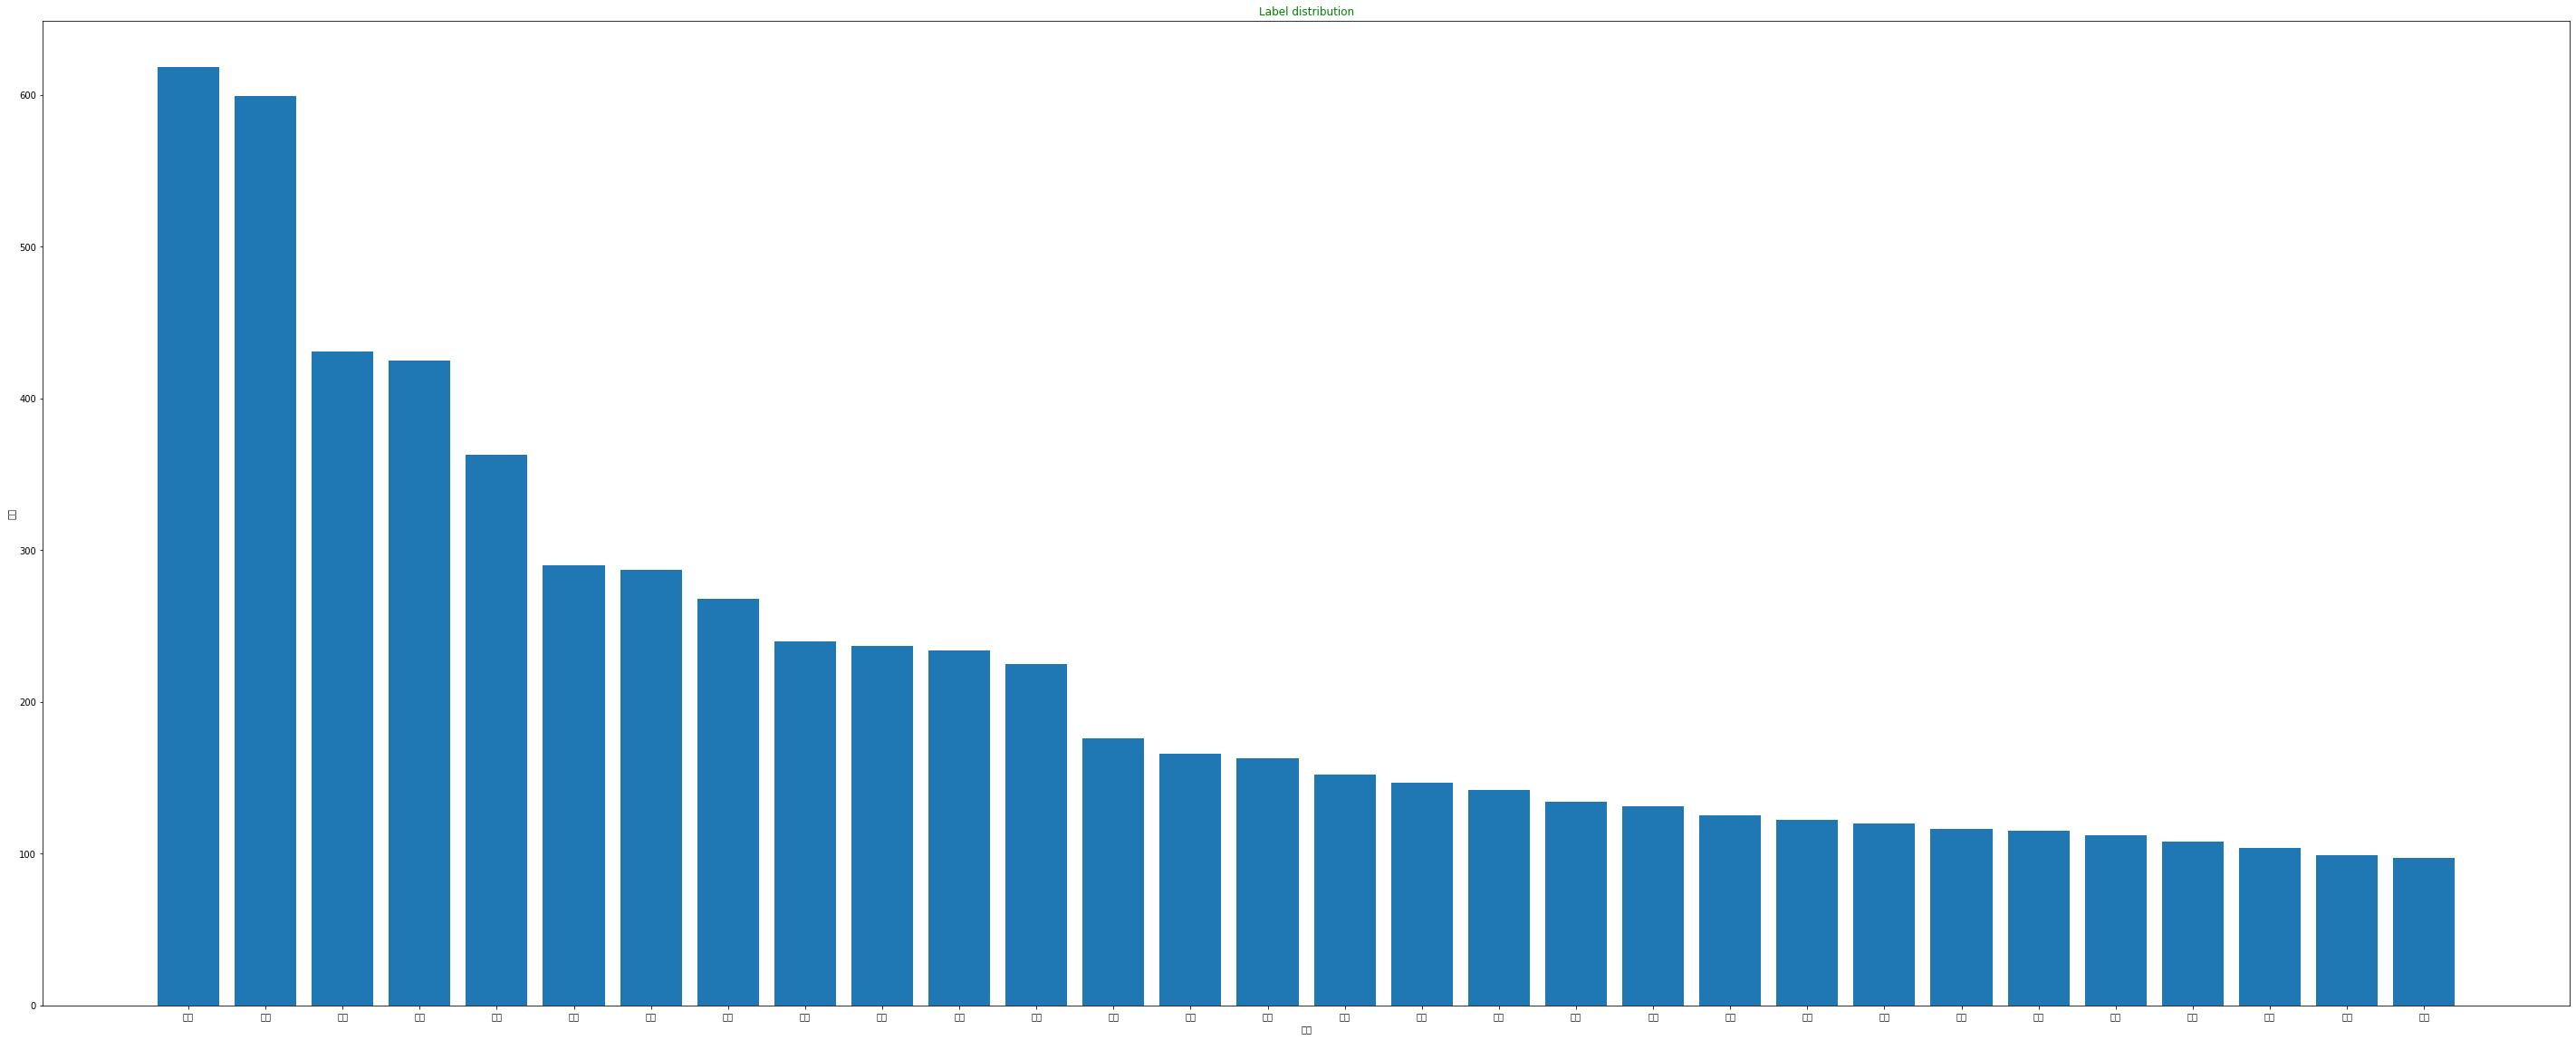

In [56]:
class_names.clear()
class_values.clear()

items = list(counts.items())
items.sort(key=lambda x: x[1], reverse=True)
for i in range(30):
    word, count = items[i]
    class_names.append(word)
    class_values.append(count)
    print("{:<10}{:>7}".format(word, count))

plt.rcParams['font.family']=['SimSun']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(50,20))
plt.bar(class_names,class_values)
plt.xlabel("分词")
plt.ylabel("词频")
plt.title("Label distribution", color="green")
plt.show()

## 切分训练集和验证集数据
1. 按照80：20比例进行切分

In [57]:
prefix = 'classification/blazingtext/bmwticket'
t_train_data = labels[0:int(len(labels)*0.8)]
t_validation_data = labels[int(len(labels)*0.8):]

In [58]:
#t_train_data[0:13]

2. 保存切分好的训练集和验证集数据

In [59]:
import csv
t_train_file = 'tt.train'
t_validation_file = 'tt.validation'

with open(t_train_file, 'w') as csvoutfile:
    csv_writer = csv.writer(csvoutfile, delimiter=' ', lineterminator='\n')
    csv_writer.writerows(t_train_data)
    
with open(t_validation_file, 'w') as csvoutfile:
    csv_writer = csv.writer(csvoutfile, delimiter=' ', lineterminator='\n')
    csv_writer.writerows(t_validation_data)

3. 上传到S3

In [60]:
%%time

t_train_channel = prefix + '/train'
t_validation_channel = prefix + '/validation'

sess.upload_data(path='tt.train', bucket=bucket, key_prefix=t_train_channel)
sess.upload_data(path='tt.validation', bucket=bucket, key_prefix=t_validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, t_train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, t_validation_channel)

s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

CPU times: user 65.9 ms, sys: 4.1 ms, total: 70 ms
Wall time: 1.21 s


## 使用BlazingText算法进行评论分类

1. 加载SageMaker BlazingText container

In [61]:
region_name = boto3.Session().region_name
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

2020-11-10 16:40:39,905:WARNING:'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Using SageMaker BlazingText container: 390948362332.dkr.ecr.cn-north-1.amazonaws.com.cn/blazingtext:latest (cn-north-1)


2. 配置BlazingText预测模型和超参调优

In [62]:
t_bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.4xlarge',
                                         train_volume_size = 120,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)
t_bt_model.set_hyperparameters(
    mode="supervised",
    epochs=20,
    min_count=2,
    learning_rate=0.1,
    vector_dim=10,
    early_stopping=True,
    patience=4,
    min_epochs=5,
    word_ngrams=1)

2020-11-10 16:41:20,085:WARNING:Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


3. 准备模型输入

In [63]:
t_train_data = sagemaker.inputs.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
t_validation_data = sagemaker.inputs.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='text/plain', s3_data_type='S3Prefix')
t_data_channels = {'train': t_train_data, 'validation': t_validation_data}

2020-11-10 16:41:28,921:WARNING:'s3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
2020-11-10 16:41:28,922:WARNING:'s3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


4. 模型训练执行

In [64]:
t_bt_model.fit(inputs=t_data_channels, logs=True)

2020-11-10 16:41:46,068:INFO:Creating training-job with name: blazingtext-2020-11-10-16-41-46-067


2020-11-10 16:41:46 Starting - Starting the training job...
2020-11-10 16:41:50 Starting - Launching requested ML instances......
2020-11-10 16:42:58 Starting - Preparing the instances for training.........
2020-11-10 16:44:43 Downloading - Downloading input data
2020-11-10 16:44:43 Training - Training image download completed. Training in progress..Arguments: train
[11/10/2020 16:44:44 WARNING 140694587671936] Loggers have already been setup.
[11/10/2020 16:44:44 WARNING 140694587671936] Loggers have already been setup.
[11/10/2020 16:44:44 INFO 140694587671936] nvidia-smi took: 0.025323867797851562 secs to identify 0 gpus
[11/10/2020 16:44:44 INFO 140694587671936] Running single machine CPU BlazingText training using supervised mode.
Number of CPU sockets found in instance is  1
[11/10/2020 16:44:44 INFO 140694587671936] Processing /opt/ml/input/data/train/tt.train . File size: 0.29093360900878906 MB
[11/10/2020 16:44:44 INFO 140694587671936] Processing /opt/ml/input/data/validation/

## 执行推理

***注意在模型训练和调优达到需要的精度前，请勿执行模型推理的端点的部署***

1. 部署模型端点

In [65]:
t_text_classifier = t_bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.c5.large')

2020-11-10 16:46:39,989:WARNING:Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
2020-11-10 16:46:39,990:INFO:Creating model with name: blazingtext-2020-11-10-16-41-46-067
2020-11-10 16:46:40,547:INFO:Creating endpoint with name blazingtext-2020-11-10-16-41-46-067


-------------!

2. 执行推理，利用输入数据中无分类的数据进行推理，精度要求85%以上

In [67]:
predict_category_result_file = 'predict_category_result.csv'
low_confidence = [] # confidence<confidence_thredhold
confidence_thredhold = 0.85

if os.path.isfile(predict_category_result_file):
    os.remove(predict_category_result_file)

with open(predict_category_result_file, 'a+') as predict_f:
    predict_f.write('category' + '|' + 'comment' + '|' + 'confidence' + '\n')

# #单机并行分词
# jieba.enable_parallel(8)
# #paddle模式，精确匹配需要关闭parallel
# #jieba.disable_parallel()
# #启动paddle模式
# jieba.enable_paddle()

for sentences in input_without_category:
    counts = {} 
    # using the same nltk tokenizer that we used during data preparation for training
    tokenized_sentences = [' '.join(with_stop_words_cut(sentences, counts))]
    #print('sentences: ', sentences, ' , jieba: ', tokenized_sentences)

    #payload = {"instances" : tokenized_sentences, "configuration": {"k": 2}}
    payload = {"instances" : tokenized_sentences}

    t_response = t_text_classifier.predict(json.dumps(payload))

    t_predictions = json.loads(t_response)
    #print(json.dumps(t_predictions, indent=2))
    predict_prob = t_predictions[0]['prob'][0]
    predict_category = t_predictions[0]['label'][0]
    if predict_prob < confidence_thredhold:
        low_confidence.append(sentences + '|' + predict_category + '|' + str(predict_prob) + '\n')
    
    with open(predict_category_result_file, 'a+') as predict_f:
        predict_f.write(sentences + '|' + predict_category + '|' + str(predict_prob) + '\n')

predict_f.close
print('total predict: ', len(input_without_category), ' , > ', confidence_thredhold, ' confidence: ', len(input_without_category) - len(low_confidence))

Building prefix dict from the default dictionary ...
2020-11-10 16:55:07,892:DEBUG:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
2020-11-10 16:55:08,610:DEBUG:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.774 seconds.
2020-11-10 16:55:08,667:DEBUG:Loading model cost 0.774 seconds.
Prefix dict has been built successfully.
2020-11-10 16:55:08,668:DEBUG:Prefix dict has been built successfully.


total predict:  637  , >  0.85  confidence:  637


3. 预测完毕，删除推理端点，节省费用

In [68]:
t_text_classifier.delete_endpoint()

2020-11-10 16:56:40,412:INFO:Deleting endpoint configuration with name: blazingtext-2020-11-10-16-41-46-067
2020-11-10 16:56:40,476:INFO:Deleting endpoint with name: blazingtext-2020-11-10-16-41-46-067
